# <a>Classification of Images - PyTorch and Transfer Learning</a>


## <a> Motivation </a>
Pre-trained networks abound; why not leverage them? Many applications addressing real-world problems can be swiftly developed using a limited set of observations for model training. Without this tool, tens of thousands of images are required to train a network from scratch, rendering it impractical in the vast majority of cases.

A convolutional neural network is intricate in its inner workings and details under the hood. However, this complexity should not deter us from employing libraries that abstract away such intricacies, thereby creating value for the companies and organizations we serve, or even showcasing our ability to utilize deep learning tools for solving potential real-world problems (and enriching our portfolios).

## <a> Object of Study </a>
Let's Veggie requires a minimum viable product that can be testd in the company's branches. The problem to be addressed is the difficulty in classifying products in the stores, as the company is experiencing rapid growth and hiring many new salespeople! Many of them are unfamiliar with distinguishing between vegetables and fruits, and an application that can perform this classification could greatly assist in the company's expansion.

We will begin with the classification of potatoes, carrots, tomatoes, and lemons.

### <a>Creation and Segregation of Datasets</a>
With the images downloaded from Google Images, we can separate them into training, validation, and test sets.

The project requires only one "raw" folder within the "data" directory, with a subfolder for each class to be trained (in our case, the vegetables we will use in the MVP).

In [50]:
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

import time
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [51]:
# First we will separate the images into training, validation and test bases
#It is interesting to leave a raw folder with the original data just in case we need it.

directory_image_base = './data/raw'
folder_with_vegetable_names = os.listdir('./data/raw')
folder_with_vegetable_names


['batata', 'cenoura', 'limao', 'tomate']

In [52]:
# Creating a stratified separation
quantity_per_label = {folder: len(os.listdir(os.path.join(directory_image_base, folder))) for folder in folder_with_vegetable_names}

quantity_per_label


{'batata': 146, 'cenoura': 181, 'limao': 111, 'tomate': 107}

In [53]:
#Creating the folders for training, validadation and test
directory_processed_images = './data/processed/'

dir_training = os.path.join(directory_processed_images, 'training')
dir_validation = os.path.join(directory_processed_images, 'validation')
dir_test = os.path.join(directory_processed_images, 'test')

if not os.path.exists(dir_training):
    os.makedirs(dir_training)

if not os.path.exists(dir_validation):    
    os.makedirs(dir_validation)

if not os.path.exists(dir_test):
    os.makedirs(dir_test)

In [54]:
import shutil
from sklearn.model_selection import train_test_split
# Criando uma folder para cada class (batata, cenoura, limao, tomate)
# dentro de training, validação e test

for classe in folder_with_vegetable_names:
    # os.path.join cria paths com os separadores corretos pra cada sistema operacional
    # barra normal, barra invertida, isso muda do Windows pro Linux/Mac
    dir_class_training = os.path.join(dir_training, classe)
    dir_class_validation = os.path.join(dir_validation, classe)
    dir_class_test = os.path.join(dir_test, classe)
    
    # Efetivamente criando as folders de training, validação e test
    # Testa primeiro se as folders já não existem
    if not os.path.exists(dir_class_training):
        os.makedirs(dir_class_training)

    if not os.path.exists(dir_class_validation):
        os.makedirs(dir_class_validation)
    
    if not os.path.exists(dir_class_test):
        os.makedirs(dir_class_test)
    
    # caminho completo para a folder com imagens originais
    folder_class = os.path.join(directory_image_base, classe)
    
    # listando todos os archives de image para essa class
    archives_class = os.listdir(folder_class)
    
    # separando 80% para training e 20% para validação+test
    training, valid_test = train_test_split(archives_class, 
                                           shuffle=True, 
                                           test_size=0.2, 
                                           random_state=42)
    
    # separando os 20% da validação+test em 10% para validação e 10% para test
    validation, test = train_test_split(valid_test, shuffle=True, test_size=0.5, random_state=42)
    
    # Não precisamos mais dessa lista temporária
    del valid_test
    
    print(f'{classe} - training: {len(training)} - valid: {len(validation)} - test: {len(test)} - total: {len(archives_class)}')
    
    # Copiando os archives efetivamente para as folders de training, validação e test
    for image_training in training:
        orgin_path = os.path.join(directory_image_base, classe, image_training)
        destination_path = os.path.join(dir_class_training, image_training)

        shutil.copy(orgin_path, destination_path)

    for image_validation in validation:
        orgin_path = os.path.join(directory_image_base, classe, image_validation)
        destination_path = os.path.join(dir_class_validation, image_validation)

        shutil.copy(orgin_path, destination_path)

    for image_test in test:
        orgin_path  = os.path.join(directory_image_base, classe, image_test)
        destination_path = os.path.join(dir_class_test, image_test)

        shutil.copy(orgin_path, destination_path)        
        
        
        
        
    

batata - training: 116 - valid: 15 - test: 15 - total: 146
cenoura - training: 144 - valid: 18 - test: 19 - total: 181
limao - training: 88 - valid: 11 - test: 12 - total: 111
tomate - training: 85 - valid: 11 - test: 11 - total: 107


### <a>Pre-processing</a>


In [55]:
#Setting image size
image_size = 100

##Transforming images: for more robust models you have to do a great job with data augmentation
# In this case I didn't do anything other than resizing the image, but it's always good to do rotations, mirroring, random crop for good measure

image_transformation = {
    'training': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    
    'validation': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),

    'test': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}


In [56]:
# Load the images
# Determine the folders

training_folder = dir_training
validation_folder = dir_validation
test_folder = dir_test

training_folder, validation_folder, test_folder

('./data/processed/training',
 './data/processed/validation',
 './data/processed/test')

#### <a>Preparation for the trainment </a>


In [57]:
batch_size = 8

number_of_classes = len(os.listdir(training_folder))
number_of_classes

4

In [58]:
#Load the images using torchvision datasets
data = {
    'training': datasets.ImageFolder(root= training_folder , transform=image_transformation['training']),
    'validation': datasets.ImageFolder(root= validation_folder , transform=image_transformation['validation'])
}

In [59]:
data

{'training': Dataset ImageFolder
     Number of datapoints: 433
     Root location: ./data/processed/training
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 55
     Root location: ./data/processed/validation
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            )}

In [60]:
# Map the indexes with the class names (each index will have a related fruit name)
index_for_class = {index: classe for classe, index in data['training'].class_to_idx.items()}

index_for_class

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [61]:
num_images_training = len(data['training'])
num_images_validation = len(data['validation'])

num_images_training, num_images_validation

(433, 55)

In [62]:
# Create DataLoaders for training and validation
# DataLoader organizes training and validation data for neural network training
data_loader_training = DataLoader(data['training'], batch_size=batch_size, shuffle=True)
data_loader_validation = DataLoader(data['validation'], batch_size=batch_size, shuffle=True)

#### <a>Transfer Learning</a>


In [63]:
alexnet = models.alexnet(pretrained=True)

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [64]:
#Freeze the parameters of the pre-trained network
#required_grad = false turns down the trainment adn the atualization

for param in alexnet.parameters():
    param.requires_grad = False

In [65]:
# Change the last layer to change the number of classes
# Remembering that we take advantage of the entire network, we only plug in one final layer  that you will effectively learn from our classes 

# Changing Linear(in_features=4096, out_features=1000, bias=True) for Linear(in_features=4096, out_features=4, bias=True), as we have 4 produce
alexnet.classifier[6] = nn.Linear(4096, number_of_classes)

# Including softmax, which makes the probabilities of being carrot, potato,lemon or tomato be 1 (effectively converts to probabilities to facilitate our
## analysis)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [66]:
parameters_last_layers = alexnet.classifier[6].parameters()

[parameter for parameter in parameters_last_layers][0].requires_grad

True

In [67]:
# Let's use the cross entropy error function, quite common for sorting issues
function_error = nn.CrossEntropyLoss()

#### <a>Optimizer</a>

The Optimizer is the one who effectively changes the network weights according to some algorithm

In this case we will use the Adam Optimizer, but it is possible to use Stochastic Gradient Descent, for example

In [68]:
optimizer = optim.Adam(alexnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

#### <a>Train and Validate</a>

The training performs several paths forward (forward: prediction), error calculations (distance between prediction and real value) and backward (backpropagation: learning from the error). At each epoch, all training images are used to optimize the network parameters. Within each epoch, we use batch training, instead of performing image-by-image training.

When validating, remember that we do not want to maintain the gradient calculation, as we will not perform backpropagation.

In [69]:
def train_and_validate(model, loss_metric, optimizer, epochs=10):
    '''
    Function for training and validation
    Parameters
        :param model: model to train and validate
        :param loss_metric: loss criterion for minimization
        :param optimizer: optimizer to update network parameters
        :param epochs: number of epochs (default=10)

    Returns
        best_model: model trained with the best validation accuracy
        history: (dictionary): history with training error, validation error, and accuracy
    '''
    
    # Initializing history
    # Best validation accuracy
    # Best model based on validation
    history = []
    best_accuracy = 0.0
    best_model = None
    
    # If you are rich and have an RTX 3090 ti (what a dream!!)
    # But if not, no problem, your CPU will probably handle it!
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print(device)
    
    # Each epoch goes through all the training images and calculates training and validation errors
    # for neural network learning
    for epoch in range(epochs):
        epoch_start = time.time()
        print("\n\nEpoch: {}/{}".format(epoch+1, epochs))
        
        # Training error and accuracy in this epoch
        train_error = 0.0
        train_corrects = 0.0
        
        # Validation error and accuracy in this epoch
        val_error = 0.0
        val_corrects = 0.0
        
        # Iterate over each batch of images. The inputs are the batch tensors
        # and the labels are the classifications of each image in the batch:
        # potato, carrot, lemon, and tomato (0, 1, 2, and 3)
        for i, (batch_images, y_true) in enumerate(data_loader_training):
            print(f"\nBatch: {i+1}\n")
            
            # Send to GPU or CPU, depending on your hardware and installed pytorch
            batch_images = batch_images.to(device)
            y_true = y_true.to(device)
            
            # Clear the gradients: zero the gradients
            optimizer.zero_grad()

            # Forward pass - calculate outputs from inputs using the model
            # Since the batch has 8 images, we will have 8 predictions
            predictions = model(batch_images)


            '''
            # Let's understand better what's going on!
            print(batch_images.size()) # we have a tensor with 8 images
            print(predictions) # we have a tensor with 8 predictions, each with 4 log-probability values
            print(torch.exp(predictions)) # converting to exponential to get real probabilities
            
            print(torch.max(predictions.data, 1))
            
            # Looking at y_true
            print(y_true)


            # Let's take a look at the images in the batch!
            for index in range(batch_size):
                tensor_to_image = transforms.ToPILImage()
                image = tensor_to_image(batch_images[index])
                display(image)

            break
            '''
                
            # Calculate the error of the predicted outputs in the forward pass
            # comparing with the actual classifications (predicted vs real)
            # and return the mean of the errors (there are 8 errors, remember?)
            loss = loss_metric(predictions, y_true)
            
            # Backpropagation is the combination of loss.backward() + optimizer.step()
            # loss.backward() calculates the gradients, i.e., which direction 
            # the coefficients should go to reduce the error
            # optimizer.step() updates the coefficients according to the gradients
            # calculated in the previous step
            
            # Calculate gradients from the prediction error
            # The optimizer will use these gradients to know
            # which direction to update the network coefficients
            loss.backward()
            
            # Update the network parameters according to the gradients calculated in backward
            optimizer.step()
            
            # From here on, we calculate the accuracy
            # to evaluate the model's evolution during training
            # in the epochs
            
            # Calculate the total error for this batch and add the training error
            # The calculated error is already the mean of the 8 errors, so we need to multiply
            # by the number of images in the batch
            train_error += loss.item() * batch_images.size(0)
            
            # Accuracy calculation
            # To calculate accuracy, we need to find the predicted classes for each image in the batch
            
            # Each tensor is an image in the batch with three positions: probabilities of each class
            # torch.max will return the value of the highest probability, 
            # as well as the position in the tensor (tuple output)
            # The position, therefore, will indicate the class with the highest probability (0, 1, 2, and 3)
            # First, find the maximum value of each tensor for each image, which will give 
            # the final predicted class
            _, predicted_classes = torch.max(predictions.data, 1)
            correct_preds = (predicted_classes == y_true).type(torch.FloatTensor)
            
            # Convert the correct predictions to float and calculate the mean accuracy
            # of the batch
            accuracy = torch.mean(correct_preds)
            
            # Calculate the total training accuracy of the entire batch and add it to train_acc
            train_corrects += torch.sum(correct_preds)
            
            #print("Training - Batch number {:03d}, Error: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), accuracy.item()))

            
        # Validation - no need to track gradients, as the model will not be trained with validation
        # "turn off" autograd
        with torch.no_grad():

            # Switch from training to validation
            model.eval()

            # Validation iteration
            for j, (batch_images, y_true) in enumerate(data_loader_validation):
                batch_images = batch_images.to(device)
                y_true = y_true.to(device)

                # Forward pass for validation
                # Model prediction in this epoch
                predictions = model(batch_images)

                # Calculate validation error
                # Predicted vs the actual fruits
                loss = loss_metric(predictions, y_true)

                # Calculate validation error and add to val_loss
                val_error += loss.item() * batch_images.size(0)

                # Calculate validation accuracy
                _, predicted_classes = torch.max(predictions.data, 1)
                correct_preds = (predicted_classes == y_true).type(torch.FloatTensor)

                # Convert the correct predictions to float and calculate the mean accuracy
                accuracy = torch.mean(correct_preds)

                # Calculate the total validation accuracy of the entire batch and add it to train_acc
                val_corrects += torch.sum(correct_preds)

                #print("Validation - Batch number: {:03d}, Error: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), accuracy.item()))
        
        #break
        
        # Calculate the mean error and accuracy in training
        mean_train_error = train_error / num_images_training
        mean_train_accuracy = train_corrects / num_images_training

        # Calculate the mean error and accuracy in validation
        mean_val_error = val_error / num_images_validation
        mean_val_accuracy = val_corrects / num_images_validation

        # Include in history the mean errors and accuracies
        history.append([mean_train_error, mean_val_error, mean_train_accuracy, mean_val_accuracy])
                
        epoch_end = time.time()
    
        print("Epoch: {:03d}, Training: Error: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Error: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, mean_train_error, mean_train_accuracy*100, mean_val_error, mean_val_accuracy*100, epoch_end-epoch_start))
        
        # Check if the validation accuracy of this model in this epoch is the best
        # If it's the best, save it as the best model and best accuracy
        if mean_val_accuracy > best_accuracy:
            best_accuracy = mean_val_accuracy
            #torch.save(model, './models/best_model.pt')
            best_model = model

    return best_model, history

In [70]:
# Define the number of epochs
num_epochs = 10

# Train the model!
trained_model, history = train_and_validate(alexnet, function_error , optimizer, num_epochs)


cpu


Epoch: 1/10

Batch: 1


Batch: 2


Batch: 3


Batch: 4


Batch: 5


Batch: 6


Batch: 7


Batch: 8


Batch: 9


Batch: 10


Batch: 11


Batch: 12


Batch: 13


Batch: 14


Batch: 15


Batch: 16


Batch: 17


Batch: 18


Batch: 19


Batch: 20


Batch: 21


Batch: 22


Batch: 23


Batch: 24


Batch: 25


Batch: 26


Batch: 27


Batch: 28


Batch: 29


Batch: 30


Batch: 31


Batch: 32


Batch: 33


Batch: 34


Batch: 35


Batch: 36


Batch: 37


Batch: 38


Batch: 39


Batch: 40


Batch: 41


Batch: 42


Batch: 43


Batch: 44


Batch: 45


Batch: 46


Batch: 47


Batch: 48


Batch: 49


Batch: 50


Batch: 51


Batch: 52


Batch: 53


Batch: 54


Batch: 55

Epoch: 001, Training: Error: 0.3508, Accuracy: 87.9908%, 
		Validation: Error: 0.0712, Accuracy: 98.1818%, Time: 4.3763s


Epoch: 2/10

Batch: 1


Batch: 2


Batch: 3


Batch: 4


Batch: 5


Batch: 6


Batch: 7


Batch: 8


Batch: 9


Batch: 10


Batch: 11


Batch: 12


Batch: 13


Batch: 14


Batch: 15


Batch: 16


Batch: 17




#### <a>History of trainment e validation</a>


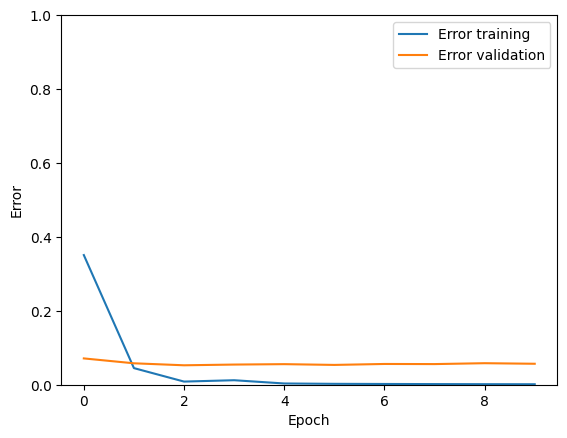

In [71]:
history = np.array(history)

plt.plot(history[:,0:2])
plt.legend(['Error training', 'Error validation'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0,1)
plt.show()



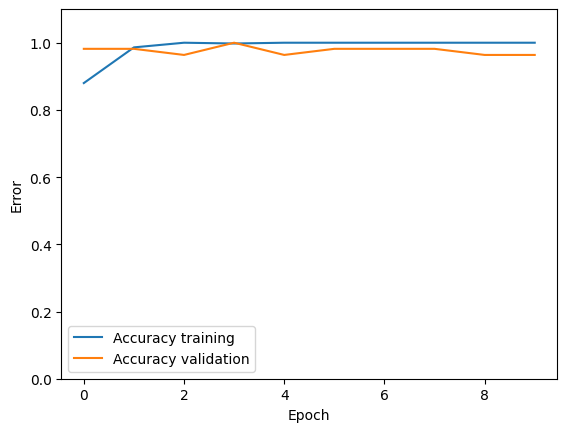

In [72]:
history = np.array(history)

plt.plot(history[:,2:])
plt.legend(['Accuracy training', 'Accuracy validation'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim(0,1.1)
plt.show()

In [73]:
def prediction_lets_veggie(image_test):
    '''
    Função para realizar a predição do status do AR
    Parâmetros
        :param image_test: image já transformada com o PIL
    '''
    transformation = image_transformation['test']
    
    tensor_test_image = transformation(image_test)

    # Testa se voce é rico, ops, se tem uma placa NVIDIA :) (ou se instalou a versão certa do PyTorch)
    if torch.cuda.is_available():
        tensor_test_image = tensor_test_image.view(1, 3, image_size, image_size).cuda()
    else:
        tensor_test_image = tensor_test_image.view(1, 3, image_size, image_size)
    
    dict_predictions = dict()
    
    # Não precisa calcular os gradientes com o autograd
    with torch.no_grad():
        trained_model.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        predictions_log = trained_model(tensor_test_image)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        predictions = torch.exp(predictions_log)
        
        dict_predictions = {index_for_class[classe]: float(predictions[0][classe]) for classe in range(number_of_classes)}
        
        #print(dict_predictions)
   
    return dict_predictions

#### <a>Prediction on test images</a>

We do not use the test images anywhere! So we learned that it should be and we will do it forever and ever as good and good data scientists.

Let's make some predictions just to "play around" and then calculate the accuracy.

In [74]:
folder_with_vegetable_names

['batata', 'cenoura', 'limao', 'tomate']

In [75]:
test_folder

'./data/processed/test'

'batata'

'cenoura'

'limao'

'tomate'

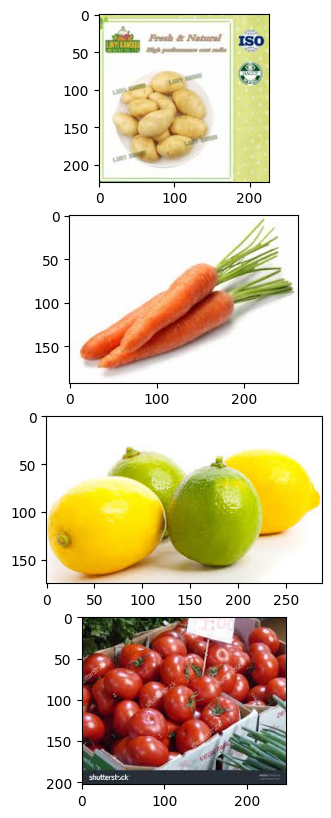

In [76]:
figure, plots = plt.subplots(nrows=number_of_classes, ncols=1, figsize=(5, 10))

for index, classe in enumerate(folder_with_vegetable_names):
    folder_test_class = os.path.join(folder_test, classe)
    image = os.path.join(folder_test_class, os.listdir(folder_test_class)[3])
    image_teste = PIL.Image.open(image)

    plots[index].imshow(image_teste)
    
    prediction = prediction_lets_veggie(image_teste)
    
    display(max(prediction, key=prediction.get))

In [83]:
# Função que perpassa todas as imagens na pasta de teste
# Realiza a predição utilizando a função prediction_lets_veggie
# e calcula a acurácia (total corrects/total imagens)
def accuracy_test(test_folder):
    corrects = 0
    images_total = 0
    
    for classe in os.listdir(test_folder):
        complete_folder = os.path.join(test_folder, classe)
        images_total += len(os.listdir(complete_folder))
        
        for image in os.listdir(complete_folder):
            image = os.path.join(complete_folder, image)
            image_teste = PIL.Image.open(image)
            predictions = prediction_lets_veggie(image_teste)
            prediction = max(predictions, key=predictions.get)

            if prediction == classe:
                corrects += 1
    
    return 100 * corrects/images_total

In [84]:
accuracy_test(test_folder)

96.49122807017544

#### <a>Model Deploy</a>


In [89]:
import gradio as gr

gradio_interface = gr.Interface(
    fn=prediction_lets_veggie,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label()
)

gradio_interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://9c9d8e7a6a505f1eed.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
